In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline

mpl.rcParams['font.size'] = 17
mpl.rcParams['axes.linewidth'] = 1.8
mpl.rcParams['xtick.major.width'] = 1.6
mpl.rcParams['ytick.major.width'] = 1.6
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['ytick.minor.size'] = 5


In [17]:
# Oumuamua distance vs time (loaded from REBOUND)
dist = np.loadtxt('oumuamua_distances.csv', delimiter=',')       # au
time = np.loadtxt('oumuamua_times.csv', delimiter=',')/(2*np.pi) # years 
d0 = np.argmin(dist)
time -= time[d0] # center t=0 at perihelion

In [18]:
# non-grav acceleration vs. distance from sun
def alpha(rr):
    return 4.92e-6*100 * (rr)**-2  # radius in au; return acceleration in cm/s^2

# Select 1.2-2.8 au range during exit from solar system
ii = np.where((time>0)&((dist>1.2)&(dist<2.8)))
alpha_ng = alpha(dist[ii]) # cm/s^2
t_sec = time[ii]*3.1536e7

In [19]:
# Constants
gamma = 8/np.pi 
kB = 1.3807e-16 # cm2 g s-2 K-1
m_h2 = 2*1.673e-24 # g
m_h2o = 18*1.673e-24 # g

In [20]:
# Variables
depth = np.linspace(50,800,1001)   # depths (cm) from which H2 outgasses
albedo = np.linspace(0.05,0.9,1000) # albedos

# Find dimensions based on albedo range
ra,rb,rc = 115e2/2,111e2/2,19e2/2  # fiducial semi axes (cm) for albedo = 0.1 
sizefac = np.sqrt(0.1/albedo)      # scaling factor for different albedos 
rra, rrb, rrc = ra*sizefac, rb*sizefac, rc*sizefac  # range of sizes based on possible albedos

# shell (r-d) for range of possible semi axes and range of possible depths
ra_s = rra[np.newaxis,:]-depth[:,np.newaxis]
rb_s = rrb[np.newaxis,:]-depth[:,np.newaxis]
rc_s = rrc[np.newaxis,:]-depth[:,np.newaxis]

# exclude unphysical parameter space (r_c - depth < 0)
rc_s[rc_s<0] = np.nan  

In [21]:
# Assumptions 
vals_Tgas_Xh2o = [[140, 0.75], [100, 0.5]] # T (K) of outflow and water:rock mass ratio; 
                                           # grouped into unconservative & conservative assumptions
vals_Xh2 = [0.3, 0.4] # H2/H2O number ratio 
vals_zeta = [0.5, 1]  # fraction of momentum in anti-solar direction: 0.5 = hemispherical, 1 = collimated


/var/folders/jq/tw5trh1543q7l6mmhf0tsjth0000gn/T/ipykernel_52541/2666744642.py:20: UserWarning: No contour levels were found within the data range.
  lines=ax[nx][pp].contour(albedo, depth, feas_ratio, levels=[1], colors='w', linestyles=ls[zn])


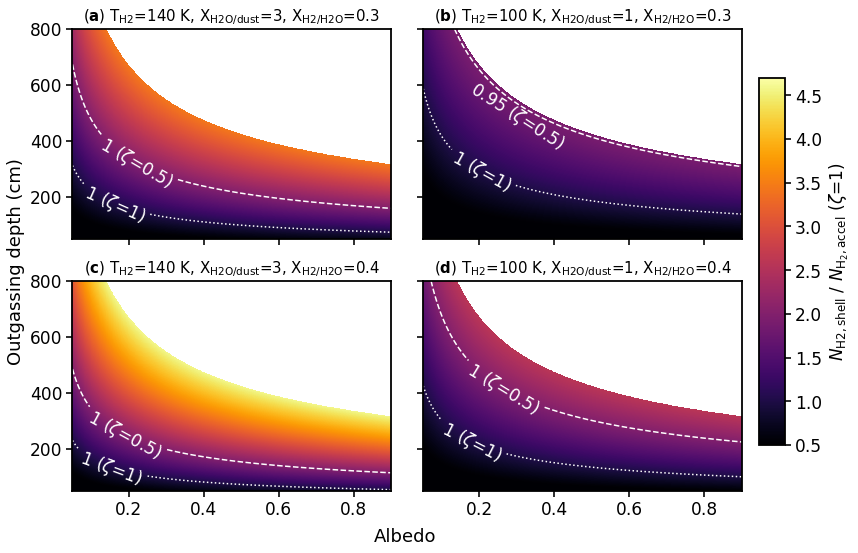

In [22]:
# Plotting
ll = ['a', 'c', 'b', 'd']
fig,ax=plt.subplots(2,2,figsize=(12,8.5))
fig.subplots_adjust(wspace=0.1, hspace=0.2, right=0.9)
ls = ['--', ':']
manual_locations = [(0.17,200)]
ct = 0
for pp, Tgas_Xh2o in enumerate(vals_Tgas_Xh2o):
    Tk, X_h2o = Tgas_Xh2o
    for nx, X_h2 in enumerate(vals_Xh2):
        for zn,zz in enumerate(vals_zeta):
            vv = np.sqrt(gamma*kB*Tk/(m_h2)) # velocity of outflowing gas; cm s^-1
            # feasibility criterion: (shell H2) / (H2 needed for acceleration)
            feas_ratio = X_h2o*X_h2 * (m_h2/m_h2o)*(1-(ra_s*rb_s*rc_s)/(rra*rrb*rrc))*vv*zz / np.trapz(alpha_ng, t_sec)
            # colormap for zeta=1 case
            if zz==1:
                aa=ax[nx][pp].pcolormesh(albedo, depth, feas_ratio, cmap='inferno', vmin=0.5,vmax=4.7, rasterized=True)
            # contours for both zeta cases
            try:
                lines=ax[nx][pp].contour(albedo, depth, feas_ratio, levels=[1], colors='w', linestyles=ls[zn])
                ax[nx][pp].clabel(lines, [1], inline=True, manual=manual_locations, fmt={1: "1 ($\zeta$=%s)"%zz})
            except:
                lines=ax[nx][pp].contour(albedo, depth, feas_ratio, levels=[0.95], colors='w', linestyles=ls[zn])
                ax[nx][pp].clabel(lines, [0.95], inline=False, manual=manual_locations, fmt={0.95: "\n0.95 ($\zeta$=%s)"%zz})
        ax[nx][pp].text(0.5,1.01, "(%s) T$_\mathrm{H2}$=%s K, X$_\mathrm{H2O/dust}$=%1.0f, X$_\mathrm{H2/H2O}$=%1.1f" 
            %(r"$\bf{%s}$"%ll[ct], Tk, X_h2o/(1-X_h2o), X_h2),
            ha='center', va='bottom', transform=ax[nx][pp].transAxes, fontsize=15)
        ct += 1

cax = plt.axes([0.92, 0.2, 0.03, 0.6])
cc=plt.colorbar(aa, cax=cax)
cc.set_label("$N_\mathrm{H2, shell}$ / $N_\mathrm{H_2, accel}$ ($\zeta$=1)", labelpad=6)

fig.text(0.51,0.05, "Albedo", ha='center',va='center', fontsize=18)
fig.text(0.06,0.5, "Outgassing depth (cm)", ha='center',va='center', rotation=90, fontsize=18)

for nn in range(2):
    ax[0][nn].set_xticklabels([])
    ax[nn][1].set_yticklabels([])
plt.savefig('H2_budget.pdf', dpi=400, bbox_inches='tight')